In [171]:
from dotenv import load_dotenv
load_dotenv()

True

In [172]:
from langchain_groq import ChatGroq
llm=ChatGroq(model="deepseek-r1-distill-llama-70b")

In [173]:
import os
from langchain_community.tools.tavily_search import TavilySearchResults
TAVILY_API_KEY=os.getenv("TAVILY_API_KEY")
search_tool=TavilySearchResults(tavily_api_key=TAVILY_API_KEY)

search_tool.invoke("What is the capital of France?")

[{'title': 'Paris facts: the capital of France in history',
  'url': 'https://home.adelphi.edu/~ca19535/page%204.html',
  'content': 'page 4\n\n===============\n\nHomeSpainSydneySan FranciscoParisLas VegasMaui\n\n Paris, France\n\nImage 1\n\nParis facts: Paris, the capital of France\n---------------------------------------------\n\nParis is the capital of France, the largest country of Europe with 550 000 km2 (65 millions inhabitants).\n\nParis has 2.234 million inhabitants end 2011. She is the core of Ile de France region (12 million people). [...] Before Paris, the capital of France was Lyon (under the Romans). Paris first became the capital of France in 508 under King Clovis. After centuries with no unique capital of France, Paris retrieved its status of capital of France under King Philippe Auguste, who reigned between 1180 and 1223. You can see remains of the Philippe August Paris walls in the passageway between the Louvre parking and Louvre Museum [...] Paris remained the capital

In [174]:
my_code = """
x=10
y=x+10
print(y)
"""

In [175]:
from langchain_experimental.utilities import PythonREPL

repl=PythonREPL()
repl.run(my_code)

'20\n'

In [176]:
from typing import Annotated
from langchain_core.tools import tool

In [177]:
@tool
def python_repl_tool(code: Annotated[str, "The python code to execute to generate your chart."]):
    """Use this to execute python code and do math. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return result_str

<>:10: SyntaxWarning: invalid escape sequence '\`'
<>:10: SyntaxWarning: invalid escape sequence '\`'
<>:10: SyntaxWarning: invalid escape sequence '\`'
<>:10: SyntaxWarning: invalid escape sequence '\`'
C:\Users\vupat\AppData\Local\Temp\ipykernel_27628\3575934677.py:10: SyntaxWarning: invalid escape sequence '\`'
  result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
C:\Users\vupat\AppData\Local\Temp\ipykernel_27628\3575934677.py:10: SyntaxWarning: invalid escape sequence '\`'
  result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"


In [178]:
python_repl_tool.invoke(my_code)

'Successfully executed:\n\\`\\`\\`python\n\nx=10\ny=x+10\nprint(y)\n\n\\`\\`\\`\nStdout: 20\n'

In [179]:
from typing import Literal
from typing_extensions import TypedDict
from langgraph.graph import MessagesState,StateGraph,START, END
from langgraph.types import Command
from langgraph.prebuilt import create_react_agent
from langchain_core.messages import HumanMessage

In [180]:
class Router(TypedDict):
    next: Literal['researcher', 'coder', 'FINISH']

In [181]:
class State(MessagesState):
    next:str

In [182]:
members=["researcher","coder"]

options = members+["FINISH"]

system_prompt = f""""
You are a supervisor, tasked with managing a conversation between the following workers: {members}. 
Given the following user request, respond with the worker to act next. 
Each worker will perform a task and respond with their results and status. 
When finished, respond with FINISH.
"""

In [183]:
def supervisor_agent(state:State)->Command[Literal['researcher', 'coder', '__end__']]:
    
    messages = [{"role": "system", "content": system_prompt},] + state["messages"]
    
    llm_with_structure_output=llm.with_structured_output(Router)
    
    response=llm_with_structure_output.invoke(messages)
    
    #this is my next worker agent
    goto=response["next"]
    
    print("**********BELOW IS MY GOTO***************")
    
    print(goto)
    
    if goto == "FINISH":
        goto=END
        
    return Command(goto=goto, update={"next":goto})

In [184]:
def research_agent(state: State) -> Command[Literal["supervisor"]]:
    
    research_agent = create_react_agent(llm, tools=[search_tool], prompt="You are a researcher. DO NOT do any math.")
    
    result=research_agent.invoke(state)
    
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="researcher")
            ]
        },
        goto="supervisor",
    )
    

In [185]:
def coder_agent(state:State)->Command[Literal['supervisor']]:
    code_agent=create_react_agent(llm,tools=[python_repl_tool], prompt="You are a coder. DO NOT do any research.")
    result=code_agent.invoke(state)
    
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="coder")
            ]
        },
        goto="supervisor",
    )
    

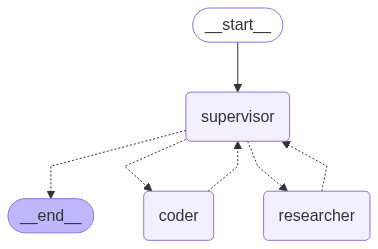

In [186]:
graph=StateGraph(State)

graph.add_node("supervisor", supervisor_agent)
graph.add_node("researcher", research_agent)
graph.add_node("coder", coder_agent)

graph.add_edge(START,"supervisor")

app=graph.compile()
app

In [187]:
for s in app.stream({"messages": [("user", "What's the square root of 42?")]}, subgraphs=True):
    print("**", s)
    print("**********BELOW IS MY STATE***************")

**********BELOW IS MY GOTO***************
researcher
** ((), {'supervisor': {'next': 'researcher'}})
**********BELOW IS MY STATE***************
** (('researcher:b2bfcf70-61bf-643b-88fb-30d133f83309',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'acep7dj8p', 'function': {'arguments': '{"query":"square root of 42"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 230, 'prompt_tokens': 179, 'total_tokens': 409, 'completion_time': 1.01083779, 'prompt_time': 0.013137626, 'queue_time': 0.055184494, 'total_time': 1.023975416}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--ef9ff0f0-a42a-483f-8829-4b6bed4c40b0-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'square root of 42'}, 'id': 'acep7dj8p', 'type': 'tool_call'}], usage_metadata={'input_tokens': 179, 'ou

KeyboardInterrupt: 

In [ ]:
for s in app.stream({"messages": [("user", "what is 2 + 2?")]}, subgraphs=True):
    print("**", s)
    print("**********BELOW IS MY STATE***************")

**********BELOW IS MY GOTO***************
coder
** ((), {'supervisor': {'next': 'coder'}})
**********BELOW IS MY STATE***************
** (('coder:4b6cc8bd-9440-da40-7c79-6b58fb458c56',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'MALFORMED_FUNCTION_CALL', 'model_name': 'gemini-1.5-flash', 'safety_ratings': []}, id='run--ef282e4f-8b3b-496b-b9c2-bc243e6662cd-0', usage_metadata={'input_tokens': 77, 'output_tokens': 0, 'total_tokens': 77, 'input_token_details': {'cache_read': 0}})]}})
**********BELOW IS MY STATE***************
** ((), {'coder': {'messages': [HumanMessage(content='', additional_kwargs={}, response_metadata={}, name='coder')]}})
**********BELOW IS MY STATE***************


c:\vijay\work\code\AI\AgenticAILearning\venv\Lib\site-packages\langchain_google_genai\chat_models.py:1568: UserWarning: HumanMessage with empty content was removed to prevent API error
  warnings.warn(


**********BELOW IS MY GOTO***************
coder
** ((), {'supervisor': {'next': 'coder'}})
**********BELOW IS MY STATE***************


c:\vijay\work\code\AI\AgenticAILearning\venv\Lib\site-packages\langchain_google_genai\chat_models.py:1568: UserWarning: HumanMessage with empty content was removed to prevent API error
  warnings.warn(


** (('coder:bb75baaf-0fdf-6924-07c5-2b60fc6f4ca4',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'MALFORMED_FUNCTION_CALL', 'model_name': 'gemini-1.5-flash', 'safety_ratings': []}, id='run--0dc17725-3260-4de7-92a9-02cd25989b88-0', usage_metadata={'input_tokens': 77, 'output_tokens': 0, 'total_tokens': 77, 'input_token_details': {'cache_read': 0}})]}})
**********BELOW IS MY STATE***************
** ((), {'coder': {'messages': [HumanMessage(content='', additional_kwargs={}, response_metadata={}, name='coder')]}})
**********BELOW IS MY STATE***************


c:\vijay\work\code\AI\AgenticAILearning\venv\Lib\site-packages\langchain_google_genai\chat_models.py:1568: UserWarning: HumanMessage with empty content was removed to prevent API error
  warnings.warn(


**********BELOW IS MY GOTO***************
coder
** ((), {'supervisor': {'next': 'coder'}})
**********BELOW IS MY STATE***************


c:\vijay\work\code\AI\AgenticAILearning\venv\Lib\site-packages\langchain_google_genai\chat_models.py:1568: UserWarning: HumanMessage with empty content was removed to prevent API error
  warnings.warn(


** (('coder:70396cfd-dd56-676f-f4aa-93461dc8a9c3',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'MALFORMED_FUNCTION_CALL', 'model_name': 'gemini-1.5-flash', 'safety_ratings': []}, id='run--5caca1be-7d3f-45df-bb85-20ed0cb4f373-0', usage_metadata={'input_tokens': 77, 'output_tokens': 0, 'total_tokens': 77, 'input_token_details': {'cache_read': 0}})]}})
**********BELOW IS MY STATE***************
** ((), {'coder': {'messages': [HumanMessage(content='', additional_kwargs={}, response_metadata={}, name='coder')]}})
**********BELOW IS MY STATE***************


c:\vijay\work\code\AI\AgenticAILearning\venv\Lib\site-packages\langchain_google_genai\chat_models.py:1568: UserWarning: HumanMessage with empty content was removed to prevent API error
  warnings.warn(


**********BELOW IS MY GOTO***************
coder
** ((), {'supervisor': {'next': 'coder'}})
**********BELOW IS MY STATE***************


c:\vijay\work\code\AI\AgenticAILearning\venv\Lib\site-packages\langchain_google_genai\chat_models.py:1568: UserWarning: HumanMessage with empty content was removed to prevent API error
  warnings.warn(


** (('coder:5fd699aa-5ce4-9a8e-5ba9-dd47900e0d6c',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'MALFORMED_FUNCTION_CALL', 'model_name': 'gemini-1.5-flash', 'safety_ratings': []}, id='run--f5391e23-2109-4716-b86a-9488bf09cebc-0', usage_metadata={'input_tokens': 77, 'output_tokens': 0, 'total_tokens': 77, 'input_token_details': {'cache_read': 0}})]}})
**********BELOW IS MY STATE***************
** ((), {'coder': {'messages': [HumanMessage(content='', additional_kwargs={}, response_metadata={}, name='coder')]}})
**********BELOW IS MY STATE***************


c:\vijay\work\code\AI\AgenticAILearning\venv\Lib\site-packages\langchain_google_genai\chat_models.py:1568: UserWarning: HumanMessage with empty content was removed to prevent API error
  warnings.warn(


**********BELOW IS MY GOTO***************
coder
** ((), {'supervisor': {'next': 'coder'}})
**********BELOW IS MY STATE***************


c:\vijay\work\code\AI\AgenticAILearning\venv\Lib\site-packages\langchain_google_genai\chat_models.py:1568: UserWarning: HumanMessage with empty content was removed to prevent API error
  warnings.warn(


** (('coder:1c99667f-7071-214f-ee4d-5f4b38618811',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'MALFORMED_FUNCTION_CALL', 'model_name': 'gemini-1.5-flash', 'safety_ratings': []}, id='run--15693914-e986-4980-a8db-3c24647b2e39-0', usage_metadata={'input_tokens': 77, 'output_tokens': 0, 'total_tokens': 77, 'input_token_details': {'cache_read': 0}})]}})
**********BELOW IS MY STATE***************
** ((), {'coder': {'messages': [HumanMessage(content='', additional_kwargs={}, response_metadata={}, name='coder')]}})
**********BELOW IS MY STATE***************


c:\vijay\work\code\AI\AgenticAILearning\venv\Lib\site-packages\langchain_google_genai\chat_models.py:1568: UserWarning: HumanMessage with empty content was removed to prevent API error
  warnings.warn(


**********BELOW IS MY GOTO***************
coder
** ((), {'supervisor': {'next': 'coder'}})
**********BELOW IS MY STATE***************


c:\vijay\work\code\AI\AgenticAILearning\venv\Lib\site-packages\langchain_google_genai\chat_models.py:1568: UserWarning: HumanMessage with empty content was removed to prevent API error
  warnings.warn(


** (('coder:db3f625a-32f5-5151-1815-5a0b27902a75',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'MALFORMED_FUNCTION_CALL', 'model_name': 'gemini-1.5-flash', 'safety_ratings': []}, id='run--5fa70f96-3531-4856-ad47-fae8c9145944-0', usage_metadata={'input_tokens': 77, 'output_tokens': 0, 'total_tokens': 77, 'input_token_details': {'cache_read': 0}})]}})
**********BELOW IS MY STATE***************
** ((), {'coder': {'messages': [HumanMessage(content='', additional_kwargs={}, response_metadata={}, name='coder')]}})
**********BELOW IS MY STATE***************


c:\vijay\work\code\AI\AgenticAILearning\venv\Lib\site-packages\langchain_google_genai\chat_models.py:1568: UserWarning: HumanMessage with empty content was removed to prevent API error
  warnings.warn(


**********BELOW IS MY GOTO***************
coder
** ((), {'supervisor': {'next': 'coder'}})
**********BELOW IS MY STATE***************


c:\vijay\work\code\AI\AgenticAILearning\venv\Lib\site-packages\langchain_google_genai\chat_models.py:1568: UserWarning: HumanMessage with empty content was removed to prevent API error
  warnings.warn(
Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-1.5-flash"
  }
  quota_value: 15
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 11
}
].

Ke

In [ ]:
for s in app.stream({"messages": [("user", "give me python code for 2 + 2")]}, subgraphs=True):
    print("**", s)
    print("**********BELOW IS MY STATE***************")

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-1.5-flash"
  }
  quota_value: 15
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 59
}
].


ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-1.5-flash"
  }
  quota_value: 15
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 57
}
]